In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import joblib
import pickle
from datetime import datetime
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
dfFinal = pd.read_csv(r'gs://cloud-ai-platform-9a0d9aeb-97fd-41ed-9a1a-8ee8a5e205bc/1million.csv').reset_index(drop=True).drop(columns = 'Unnamed: 0')

In [3]:
xcols = ['inlandDistance', 'elevation', 'waterDistance', 'waterLevel', 'bathtubDepth']
ycols = ['difference']
indices = dfFinal.index
x = dfFinal[xcols]
y = dfFinal[ycols]

In [4]:
X = x.to_numpy()
y = y.to_numpy()

In [5]:
# Binning continous target values into 150 bins and encoding into one-hot vectors for multiclass classification 
est = KBinsDiscretizer(n_bins=100, encode='ordinal', strategy='uniform')
labels = est.fit(y.reshape(-1,1))
labels = est.transform(y.reshape(-1,1))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42) 

In [7]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val =  scaler.fit_transform(X_val)

In [8]:
y_train = y_train.ravel()
y_val = y_val.ravel()
y_test = y_test.ravel()

In [9]:
n_estimators = [300]
max_depth = [10,20,40]
param_grid = {'max_depth':max_depth, 'n_estimators':n_estimators}
rfc = RandomForestClassifier(random_state=42)

In [11]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='accuracy', verbose=4, error_score = 'raise')
CV_rfc

GridSearchCV(error_score='raise',
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 20, 40], 'n_estimators': [300]},
             scoring='accuracy', verbose=4)

In [12]:
print(datetime.now())
CV_rfc.fit(X_train, y_train)
print(datetime.now())

2022-12-02 05:40:31.231236
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


[CV 1/5] END ....max_depth=10, n_estimators=300;, score=0.757 total time= 9.6min
[CV 2/5] END ....max_depth=10, n_estimators=300;, score=0.757 total time= 9.8min
[CV 3/5] END ....max_depth=10, n_estimators=300;, score=0.757 total time= 9.4min
[CV 4/5] END ....max_depth=10, n_estimators=300;, score=0.758 total time= 9.3min
[CV 5/5] END ....max_depth=10, n_estimators=300;, score=0.760 total time= 9.3min
[CV 1/5] END ....max_depth=20, n_estimators=300;, score=0.786 total time=14.2min
[CV 2/5] END ....max_depth=20, n_estimators=300;, score=0.785 total time=14.2min
[CV 3/5] END ....max_depth=20, n_estimators=300;, score=0.786 total time=14.4min
[CV 4/5] END ....max_depth=20, n_estimators=300;, score=0.786 total time=14.2min
[CV 5/5] END ....max_depth=20, n_estimators=300;, score=0.786 total time=14.4min
[CV 1/5] END ....max_depth=40, n_estimators=300;, score=0.783 total time=16.2min
[CV 2/5] END ....max_depth=40, n_estimators=300;, score=0.782 total time=16.4min
[CV 3/5] END ....max_depth=4

In [23]:
CV_results = CV_rfc.cv_results_
CV_results = pd.DataFrame(CV_results)

In [24]:
CV_results.to_csv('CV_results_n_estimators300_maxdepth10_20_40')

In [25]:
CV_results[['param_max_depth', 'param_n_estimators', 'mean_test_score', 'mean_fit_time']]

,param_max_depth,param_n_estimators,mean_test_score,mean_fit_time
0,10,300,0.757639,539.464475
1,20,300,0.785906,816.953022
2,40,300,0.782305,935.206502


In [18]:
CV_rfc.cv_results_
CV_results = pd.DataFrame(CV_results)[['param_max_depth', 'param_n_estimators', 'mean_test_score', 'mean_fit_time']]

In [22]:
CV_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,539.464475,10.173202,29.418556,0.205858,10,300,"{'max_depth': 10, 'n_estimators': 300}",0.756719,0.756988,0.756663,0.757750,0.760075,0.757639,0.001278,3
1,816.953022,4.526571,38.272310,1.414261,20,300,"{'max_depth': 20, 'n_estimators': 300}",0.786044,0.785319,0.786125,0.786225,0.785819,0.785906,0.000323,1
2,935.206502,6.396553,44.346747,1.732793,40,300,"{'max_depth': 40, 'n_estimators': 300}",0.782513,0.781619,0.782419,0.782713,0.782262,0.782305,0.000373,2


Text(0.5, 1.05, '5-fold Grid Search CV Validation errors')

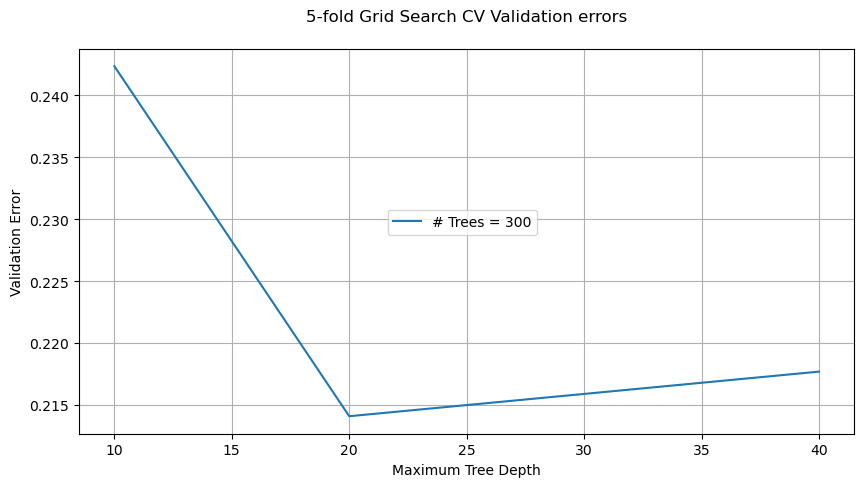

In [27]:
plt.figure(figsize = (10,5))

plt.grid()
for m in n_estimators:
    plt.plot(CV_results[CV_results.param_n_estimators == m].param_max_depth, 1 - CV_results[CV_results.param_n_estimators == m].mean_test_score, label = f'# Trees = {m}')
    plt.legend(bbox_to_anchor = (0.6, 0.6))
    plt.xlabel('Maximum Tree Depth')
    plt.ylabel('Validation Error')

plt.title('5-fold Grid Search CV Validation errors', y = 1.05)

In [29]:
pd.read_csv(r'/Users/raghavsharma/Library/CloudStorage/OneDrive-Stanford/Fall 22/CS 229/Project/RFC_CV.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'CV_results_maxdepth50-200_ntrees100-300-Copy1.csv'